In [1]:
import pandas as pd
import numpy as np
import jieba
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.test.utils import datapath
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import os
import re
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

## 读取数据

In [2]:
file_path = "../../nlp_data_set/datasource/movie_comments.csv"

In [3]:
comments_data = pd.read_csv(file_path)

In [4]:
comments_data.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


## 数据分析和预处理

In [5]:
comments_data.shape

(261497, 5)

In [6]:
len(set(comments_data['name'])) # 电影数量

2760

In [7]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261497 entries, 0 to 261496
Data columns (total 5 columns):
id         261497 non-null object
link       261497 non-null object
name       261497 non-null object
comment    261495 non-null object
star       261497 non-null object
dtypes: object(5)
memory usage: 10.0+ MB


In [8]:
comments_data.dropna(subset=['comment', 'star', 'name'], inplace=True) 

In [9]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261495 entries, 0 to 261496
Data columns (total 5 columns):
id         261495 non-null object
link       261495 non-null object
name       261495 non-null object
comment    261495 non-null object
star       261495 non-null object
dtypes: object(5)
memory usage: 12.0+ MB


In [10]:
set(comments_data['star'])

{1, '1', 2, '2', 3, '3', 4, '4', '5', 5, 'star'}

In [11]:
error_index = comments_data[comments_data['star'] == 'star'].index
comments_data = comments_data.drop(error_index)

In [12]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261494 entries, 0 to 261496
Data columns (total 5 columns):
id         261494 non-null object
link       261494 non-null object
name       261494 non-null object
comment    261494 non-null object
star       261494 non-null object
dtypes: object(5)
memory usage: 12.0+ MB


In [13]:
comments = comments_data['comment']

In [14]:
save_words_path = 'cut_words_result.txt'
save_movie_model = 'movie_model'

In [15]:
def is_chinese(word):
    for ch in list(word):
        if ch < u'\u4e00' or ch > u'\u9fff':
            return False
    return True

def cut_word(comments):
    with open(save_words_path, 'w', encoding='utf8') as f:
        for comment in tqdm(comments):
            words = jieba.cut(comment)
            com_words = []
            for word in words:
                if not is_chinese(word): continue
                com_words.append(word)
            f.write(' '.join(com_words)+'\n')

In [16]:
cut_word(comments)

  0%|          | 0/261494 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/dp/9d1tlc2926x2djj4c05f3325ps5m7_/T/jieba.cache
Loading model cost 0.998 seconds.
Prefix dict has been built succesfully.
100%|██████████| 261494/261494 [00:56<00:00, 4666.82it/s]


In [18]:
sentences = LineSentence(save_words_path)
model = Word2Vec(sentences, size=300, min_count=100, window=7)
model.save(save_movie_model)

In [19]:
model = Word2Vec.load(save_movie_model)

In [20]:
model.most_similar('垃圾')

[('狗屎', 0.6862924098968506),
 ('脑残', 0.6309102773666382),
 ('浪费时间', 0.6212705373764038),
 ('奇葩', 0.6080566048622131),
 ('圈钱', 0.5859946012496948),
 ('屎', 0.5807947516441345),
 ('骗钱', 0.5799087882041931),
 ('尼玛', 0.5606838464736938),
 ('抄', 0.5552768707275391),
 ('棒子', 0.5498322248458862)]

In [21]:
model.most_similar('好看')

[('好笑', 0.6597771644592285),
 ('难看', 0.6569291353225708),
 ('耐看', 0.611913800239563),
 ('过瘾', 0.5967444181442261),
 ('好玩', 0.58929443359375),
 ('有意思', 0.5863815546035767),
 ('漂亮', 0.5550641417503357),
 ('带劲', 0.5428954362869263),
 ('带感', 0.5409732460975647),
 ('吓人', 0.5346270203590393)]

In [22]:
len(model.wv['垃圾'])

300

## 向量化（TF-IDF）

In [23]:
def get_contents(texts):
    contents = []
    for text in tqdm(texts):
        sentence = ''.join(re.findall(r'\w+', text))
        contents.append(' '.join(jieba.cut(sentence)))
    return contents

In [24]:
_comments = get_contents(comments)

100%|██████████| 261494/261494 [00:42<00:00, 6109.74it/s]


In [25]:
vectorizer = TfidfVectorizer(max_features=100)
vectors = vectorizer.fit_transform(_comments)

In [26]:
X = vectors.toarray()

In [27]:
X.shape, comments.shape

((261494, 100), (261494,))

In [28]:
_y = comments_data['star'].tolist()

In [29]:
y = [int(i) for i in _y if str(i).isdigit()]

In [30]:
all_data = np.column_stack((X, np.array(y)))

In [31]:
all_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.48153594, 0.        ,
        2.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ]])

## 数据集拆分(训练、测试、验证)

In [32]:
def split_data(all_list, shuffle=False, test_ratio=0.2, vaild_ratio=0.2):
    num = len(all_list)
    offset1 = int(num * (1 - (test_ratio + vaild_ratio)))
    if shuffle:
        random.shuffle(all_list)  # 列表随机排序
    last_list = all_list[offset1:]
    offset2 = offset1 + int(len(last_list) * test_ratio/(test_ratio + vaild_ratio))
    return all_list[:offset1], all_list[offset1:offset2], all_list[offset2:]

In [33]:
train_data, test_data, vaild_data = split_data(all_data, shuffle=True)

In [34]:
train_data.shape, test_data.shape, vaild_data.shape

((156896, 101), (52299, 101), (52299, 101))

In [35]:
train_dataset = train_data[:,:-1].astype(np.float32)
train_labels = train_data[:,-1:].astype(np.float32).reshape(-1)
test_dataset = test_data[:,:-1].astype(np.float32)
test_labels = test_data[:,-1:].astype(np.float32).reshape(-1)
valid_dataset = vaild_data[:,:-1].astype(np.float32)
valid_labels = vaild_data[:,-1:].astype(np.float32).reshape(-1)

In [36]:
train_dataset.shape, test_dataset.shape, valid_dataset.shape

((156896, 100), (52299, 100), (52299, 100))

In [37]:
train_labels.shape, test_labels.shape, valid_labels.shape

((156896,), (52299,), (52299,))

In [38]:
num_labels = 5
def reformat(dataset, labels):
    dataset = dataset.astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (156896, 100) (156896, 5)
Validation set (52299, 100) (52299, 5)
Test set (52299, 100) (52299, 5)


In [39]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [47]:
batch_size = 500
num_steps = 1000
hidden_nodes = 300
lables_n = 5
n_length = train_dataset.shape[0]
n_features = train_dataset.shape[1]
lr = 0.005

Initialized
Minibatch loss at step 0: 14.607672
Minibatch accuracy: 14.2%
Validation accuracy: 17.1%
Minibatch loss at step 100: 2.170747
Minibatch accuracy: 17.6%
Validation accuracy: 21.6%
Minibatch loss at step 200: 2.086308
Minibatch accuracy: 22.2%
Validation accuracy: 22.1%
Minibatch loss at step 300: 1.863888
Minibatch accuracy: 21.0%
Validation accuracy: 22.1%
Minibatch loss at step 400: 1.721129
Minibatch accuracy: 20.6%
Validation accuracy: 22.2%
Minibatch loss at step 500: 1.781792
Minibatch accuracy: 24.4%
Validation accuracy: 22.7%
Minibatch loss at step 600: 1.881704
Minibatch accuracy: 21.4%
Validation accuracy: 23.1%
Minibatch loss at step 700: 1.916193
Minibatch accuracy: 23.8%
Validation accuracy: 23.0%
Minibatch loss at step 800: 1.865577
Minibatch accuracy: 24.6%
Validation accuracy: 23.0%
Minibatch loss at step 900: 1.772483
Minibatch accuracy: 27.0%
Validation accuracy: 23.1%
Test accuracy: 23.7%


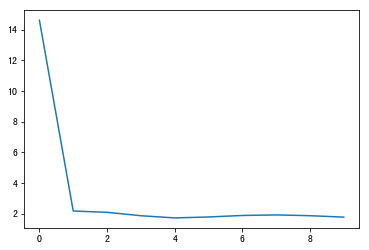

In [48]:
graph = tf.Graph()
with graph.as_default():
    # datasets
    train_X = tf.placeholder(tf.float32, shape=(batch_size, n_features))
    train_y = tf.placeholder(tf.float32, shape=(batch_size, lables_n))
    valid_X = tf.constant(valid_dataset)
    test_X = tf.constant(test_dataset)

    # --------Create the first layer (1024 hidden nodes)--------
    W1 = tf.Variable(tf.truncated_normal([n_features, hidden_nodes]))
    b1 = tf.Variable(tf.zeros([hidden_nodes]))
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(train_X, W1), b1))

    # --------Create second layer (10 hidden nodes)--------
    W2 = tf.Variable(tf.truncated_normal([hidden_nodes, lables_n]))
    b2 = tf.Variable(tf.zeros([lables_n]))
    logits = tf.add(tf.matmul(layer_1, W2), b2)

    # Minimize error using cross entropy
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))

    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)

    # Predictions for the training, validation, and test data.
    pre_train_y = tf.nn.relu(tf.add(tf.matmul(train_X, W1), b1))
    train_prediction = tf.nn.softmax(tf.add(tf.matmul(pre_train_y, W2), b2))

    valid_y = tf.nn.relu(tf.add(tf.matmul(valid_X, W1), b1))
    valid_prediction = tf.nn.softmax(tf.add(tf.matmul(valid_y, W2), b2))

    test_y = tf.nn.relu(tf.add(tf.matmul(test_X, W1), b1))
    test_prediction = tf.nn.softmax(tf.add(tf.matmul(test_y, W2), b2))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    losses = []
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {train_X : batch_data, train_y : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], 
                                        feed_dict=feed_dict)
        if (step % 100 == 0): 
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), 
                                                           valid_labels))
            losses.append(l)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    plt.plot(losses)